# BPTT (backpropagation through time)

## モデルの定義

ライブラリの読み込み．

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using Random, ProgressMeter, PyPlot

In [2]:
f(x) = tanh(x)
df(x) = 1 - tanh(x)^2;

In [3]:
@kwdef struct RNNParameter{FT}
    dt::FT = 1 # time step (ms)
    τ::FT = 10 # time constant (ms)
    α::FT = dt / τ 
    η::FT = 1e-2 # learning rate
end

`w_in`は入力層から再帰層への重み，`w_rec`は再帰重み，`w_out`は出力重みである．

In [4]:
@kwdef mutable struct RNN{FT}
    param::RNNParameter = RNNParameter{FT}()
    
    n_batch::UInt32 # batch size
    n_in::UInt32 # number of input units
    n_rec::UInt32 # number of recurrent units
    n_out::UInt32 # number of output units
    
    h0::Array{FT} = zeros(n_batch, n_rec) # initial state of recurrent units

    # weights
    w_in::Array{FT} = 0.1*(rand(n_in, n_rec) .- 1)
    w_rec::Array{FT} = 1.5*randn(n_rec, n_rec)/sqrt(n_rec)
    w_out::Array{FT} = 0.1*(2*rand(n_rec, n_out) .- 1)/sqrt(n_rec)
    bias::Array{FT} = zeros(1, n_rec)
    
    # changes to weights
    dw_in::Array{FT} = zero(w_in)
    dw_rec::Array{FT} = zero(w_rec)
    dw_out::Array{FT} = zero(w_out)
    dbias::Array{FT} = zero(bias)
end

## 7.9.2 更新関数の定義

In [5]:
function update!(variable::RNN, param::RNNParameter, x::Array, y::Array, training::Bool)
    @unpack n_batch, n_in, n_rec, n_out, h0, w_in, w_rec, w_out, bias, dw_in, dw_rec, dw_out, dbias = variable 
    @unpack dt, τ, α, η = param

    t_max = size(x)[2]  # number of timesteps
    u, h = zeros(n_batch, t_max, n_rec), zeros(n_batch, t_max, n_rec) # input (feedforward + recurrent), time-dependent RNN activity vector
    h[:, 1, :] = h0  # initial state

    ŷ = zeros(n_batch, t_max, n_out)  # RNN output
    error = zeros(n_batch, t_max, n_out)  # readout error

    for t in 1:t_max-1
        u[:, t+1, :] = h[:, t, :] * w_rec + x[:, t+1, :] * w_in .+ bias
        h[:, t+1, :] = h[:, t, :] + α * (-h[:, t, :] + f.(u[:, t+1, :]))
        ŷ[:, t+1, :] = h[:, t+1, :] * w_out 
        error[:, t+1, :] = y[:, t+1, :] - ŷ[:, t+1, :]  # readout error
    end
    
    
    # backward
    if training 
        z = zero(h)
        z[:, end, :] = error[:, end, :] * w_out' 

        for t in t_max:-1:1
            zu = z[:, t, :] .* df.(u[:, t, :])
            if t ≥ 2
                z[:, t-1, :] = z[:, t, :] * (1 - α) + error[:, t, :] * w_out' + zu * w_rec * α
                dw_rec[:, :] += h[:, t-1, :]' * zu
            end

            # Updates  Δweights:
            dw_out[:, :] += h[:, t, :]' * error[:, t, :]
            dw_in[:, :]  += x[:, t, :]' * zu
            dbias[:, :] .+= sum(zu)
        end
        
        # update weights
        w_out[:, :] += η / t_max * dw_out
        w_rec[:, :] += η / t_max * α * dw_rec
        w_in[:, :]  += η / t_max * α * dw_in
        bias[:, :]  += η / t_max * α * dbias
        
        # reset
        dw_in[:, :]  = zero(w_in)
        dw_rec[:, :] = zero(w_rec)
        dw_out[:, :] = zero(w_out)
        dbias[:, :]  = zero(bias)
    end

    return error, ŷ, h
end

update! (generic function with 1 method)

## 正弦波の学習
例として正弦波を出力するRNNを考える．入力1,中間64, 出力2のRNNである．

In [6]:
nt = 100  # number of timesteps in one period
n_batch = 1 # batch size
n_in = 1 # number of inputs
n_out = 2 # number of outputs

begin_input = 0 # begin time steps of input
end_input = 30  # end time steps of input

tsteps = 0:nt-1　# array of time steps
x = ones(n_batch) * (begin_input .≤ tsteps .≤ end_input)'  # input array

y = zeros(n_batch, nt, n_out) # target array
y[:, begin_input+1:end, 1] = sin.(tsteps[1:end-begin_input]*0.1)
y[:, begin_input+1:end, 2] = sin.(tsteps[1:end-begin_input]*0.2)

n_epoch = 25000 # number of epoch

# memory array of each epoch error
error_arr = zeros(Float32, n_epoch); 

入力と訓練データの確認をする．

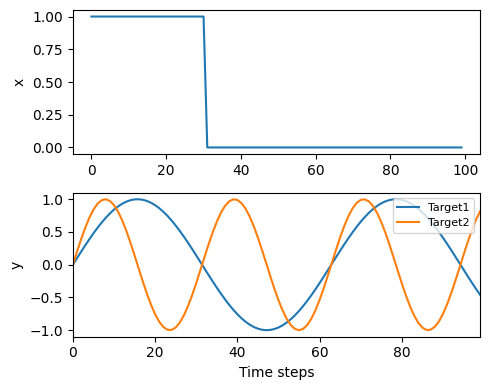

In [7]:
figure(figsize=(5, 4))
subplot(2,1,1); plot(x[1, :]); ylabel("x")
subplot(2,1,2); plot(tsteps, y[1, :, 1], label="Target1"); plot(tsteps, y[1, :, 2], label="Target2")
xlabel("Time steps"); ylabel("y"); xlim(0, tsteps[end])
legend(loc="upper right", fontsize=8)
tight_layout()

モデルの定義をする．

In [8]:
rnn = RNN{Float32}(n_batch=n_batch, n_in=n_in, n_rec=32, n_out=n_out);

学習を実行する．

In [9]:
@showprogress "Training..." for e in 1:n_epoch
    error, ŷ, h = update!(rnn, rnn.param, x, y, true)
    error_arr[e] = sum(error .^ 2)
end

Training...   0%|█                                       |  ETA: 18:29:05

Training...   1%|█                                       |  ETA: 0:19:30

Training...   1%|█                                       |  ETA: 0:12:56

Training...   1%|█                                       |  ETA: 0:11:26

Training...   1%|█                                       |  ETA: 0:10:16

Training...   1%|█                                       |  ETA: 0:09:19

Training...   1%|█                                       |  ETA: 0:08:35

Training...   1%|█                                       |  ETA: 0:07:58

Training...   2%|█                                       |  ETA: 0:07:26

Training...   2%|█                                       |  ETA: 0:07:00

Training...   2%|█                                       |  ETA: 0:06:37

Training...   2%|█                                       |  ETA: 0:06:17

Training...   2%|█                                       |  ETA: 0:06:00

Training...   2%|█                                       |  ETA: 0:05:43

Training...   2%|█                                       |  ETA: 0:05:28

Training...   2%|█                                       |  ETA: 0:05:16

Training...   2%|█                                       |  ETA: 0:05:06

Training...   3%|██                                      |  ETA: 0:04:56

Training...   3%|██                                      |  ETA: 0:04:46

Training...   3%|██                                      |  ETA: 0:04:37

Training...   3%|██                                      |  ETA: 0:04:29

Training...   3%|██                                      |  ETA: 0:04:22

Training...   3%|██                                      |  ETA: 0:04:15

Training...   3%|██                                      |  ETA: 0:04:08

Training...   3%|██                                      |  ETA: 0:04:01

Training...   4%|██                                      |  ETA: 0:03:56

Training...   4%|██                                      |  ETA: 0:03:50

Training...   4%|██                                      |  ETA: 0:03:45

Training...   4%|██                                      |  ETA: 0:03:40

Training...   4%|██                                      |  ETA: 0:03:35

Training...   4%|██                                      |  ETA: 0:03:31

Training...   4%|██                                      |  ETA: 0:03:27

Training...   4%|██                                      |  ETA: 0:03:23

Training...   5%|██                                      |  ETA: 0:03:19

Training...   5%|██                                      |  ETA: 0:03:15

Training...   5%|██                                      |  ETA: 0:03:12

Training...   5%|██                                      |  ETA: 0:03:09

Training...   5%|███                                     |  ETA: 0:03:06

Training...   5%|███                                     |  ETA: 0:03:03

Training...   5%|███                                     |  ETA: 0:03:00

Training...   5%|███                                     |  ETA: 0:02:58

Training...   6%|███                                     |  ETA: 0:02:55

Training...   6%|███                                     |  ETA: 0:02:52

Training...   6%|███                                     |  ETA: 0:02:50

Training...   6%|███                                     |  ETA: 0:02:47

Training...   6%|███                                     |  ETA: 0:02:44

Training...   6%|███                                     |  ETA: 0:02:42

Training...   6%|███                                     |  ETA: 0:02:38

Training...   7%|███                                     |  ETA: 0:02:36

Training...   7%|███                                     |  ETA: 0:02:33

Training...   7%|███                                     |  ETA: 0:02:31

Training...   7%|███                                     |  ETA: 0:02:28

Training...   7%|███                                     |  ETA: 0:02:25

Training...   8%|████                                    |  ETA: 0:02:22

Training...   8%|████                                    |  ETA: 0:02:20

Training...   8%|████                                    |  ETA: 0:02:17

Training...   8%|████                                    |  ETA: 0:02:15

Training...   8%|████                                    |  ETA: 0:02:12

Training...   9%|████                                    |  ETA: 0:02:10

Training...   9%|████                                    |  ETA: 0:02:07

Training...   9%|████                                    |  ETA: 0:02:05

Training...   9%|████                                    |  ETA: 0:02:03

Training...   9%|████                                    |  ETA: 0:02:01

Training...  10%|████                                    |  ETA: 0:01:59

Training...  10%|████                                    |  ETA: 0:01:57

Training...  10%|█████                                   |  ETA: 0:01:55

Training...  10%|█████                                   |  ETA: 0:01:53

Training...  10%|█████                                   |  ETA: 0:01:52

Training...  11%|█████                                   |  ETA: 0:01:50

Training...  11%|█████                                   |  ETA: 0:01:49

Training...  11%|█████                                   |  ETA: 0:01:47

Training...  11%|█████                                   |  ETA: 0:01:46

Training...  12%|█████                                   |  ETA: 0:01:44

Training...  12%|█████                                   |  ETA: 0:01:43

Training...  12%|█████                                   |  ETA: 0:01:42

Training...  12%|█████                                   |  ETA: 0:01:40

Training...  12%|█████                                   |  ETA: 0:01:39

Training...  13%|██████                                  |  ETA: 0:01:38

Training...  13%|██████                                  |  ETA: 0:01:37

Training...  13%|██████                                  |  ETA: 0:01:36

Training...  13%|██████                                  |  ETA: 0:01:34

Training...  13%|██████                                  |  ETA: 0:01:33

Training...  14%|██████                                  |  ETA: 0:01:32

Training...  14%|██████                                  |  ETA: 0:01:31

Training...  14%|██████                                  |  ETA: 0:01:30

Training...  14%|██████                                  |  ETA: 0:01:29

Training...  15%|██████                                  |  ETA: 0:01:28

Training...  15%|██████                                  |  ETA: 0:01:28

Training...  15%|███████                                 |  ETA: 0:01:27

Training...  15%|███████                                 |  ETA: 0:01:26

Training...  15%|███████                                 |  ETA: 0:01:25

Training...  16%|███████                                 |  ETA: 0:01:24

Training...  16%|███████                                 |  ETA: 0:01:23

Training...  16%|███████                                 |  ETA: 0:01:23

Training...  16%|███████                                 |  ETA: 0:01:22

Training...  16%|███████                                 |  ETA: 0:01:21

Training...  17%|███████                                 |  ETA: 0:01:20

Training...  17%|███████                                 |  ETA: 0:01:20

Training...  17%|███████                                 |  ETA: 0:01:19

Training...  17%|███████                                 |  ETA: 0:01:18

Training...  18%|████████                                |  ETA: 0:01:18

Training...  18%|████████                                |  ETA: 0:01:17

Training...  18%|████████                                |  ETA: 0:01:16

Training...  18%|████████                                |  ETA: 0:01:16

Training...  18%|████████                                |  ETA: 0:01:15

Training...  19%|████████                                |  ETA: 0:01:15

Training...  19%|████████                                |  ETA: 0:01:14

Training...  19%|████████                                |  ETA: 0:01:13

Training...  19%|████████                                |  ETA: 0:01:13

Training...  20%|████████                                |  ETA: 0:01:12

Training...  20%|████████                                |  ETA: 0:01:12

Training...  20%|████████                                |  ETA: 0:01:11

Training...  20%|█████████                               |  ETA: 0:01:11

Training...  20%|█████████                               |  ETA: 0:01:10

Training...  21%|█████████                               |  ETA: 0:01:10

Training...  21%|█████████                               |  ETA: 0:01:09

Training...  21%|█████████                               |  ETA: 0:01:08

Training...  21%|█████████                               |  ETA: 0:01:08

Training...  21%|█████████                               |  ETA: 0:01:07

Training...  22%|█████████                               |  ETA: 0:01:07

Training...  22%|█████████                               |  ETA: 0:01:06

Training...  22%|█████████                               |  ETA: 0:01:06

Training...  22%|█████████                               |  ETA: 0:01:05

Training...  23%|██████████                              |  ETA: 0:01:05

Training...  23%|██████████                              |  ETA: 0:01:05

Training...  23%|██████████                              |  ETA: 0:01:04

Training...  23%|██████████                              |  ETA: 0:01:04

Training...  23%|██████████                              |  ETA: 0:01:03

Training...  24%|██████████                              |  ETA: 0:01:03

Training...  24%|██████████                              |  ETA: 0:01:02

Training...  24%|██████████                              |  ETA: 0:01:02

Training...  24%|██████████                              |  ETA: 0:01:02

Training...  25%|██████████                              |  ETA: 0:01:01

Training...  25%|██████████                              |  ETA: 0:01:01

Training...  25%|██████████                              |  ETA: 0:01:00

Training...  25%|███████████                             |  ETA: 0:01:00

Training...  25%|███████████                             |  ETA: 0:01:00

Training...  26%|███████████                             |  ETA: 0:00:59

Training...  26%|███████████                             |  ETA: 0:00:59

Training...  26%|███████████                             |  ETA: 0:00:59

Training...  26%|███████████                             |  ETA: 0:00:58

Training...  27%|███████████                             |  ETA: 0:00:58

Training...  27%|███████████                             |  ETA: 0:00:58

Training...  27%|███████████                             |  ETA: 0:00:57

Training...  27%|███████████                             |  ETA: 0:00:57

Training...  27%|███████████                             |  ETA: 0:00:57

Training...  28%|████████████                            |  ETA: 0:00:56

Training...  28%|████████████                            |  ETA: 0:00:56

Training...  28%|████████████                            |  ETA: 0:00:56

Training...  28%|████████████                            |  ETA: 0:00:55

Training...  28%|████████████                            |  ETA: 0:00:55

Training...  29%|████████████                            |  ETA: 0:00:55

Training...  29%|████████████                            |  ETA: 0:00:54

Training...  29%|████████████                            |  ETA: 0:00:54

Training...  29%|████████████                            |  ETA: 0:00:54

Training...  29%|████████████                            |  ETA: 0:00:53

Training...  30%|████████████                            |  ETA: 0:00:53

Training...  30%|████████████                            |  ETA: 0:00:53

Training...  30%|█████████████                           |  ETA: 0:00:53

Training...  30%|█████████████                           |  ETA: 0:00:52

Training...  31%|█████████████                           |  ETA: 0:00:52

Training...  31%|█████████████                           |  ETA: 0:00:52

Training...  31%|█████████████                           |  ETA: 0:00:51

Training...  31%|█████████████                           |  ETA: 0:00:51

Training...  31%|█████████████                           |  ETA: 0:00:51

Training...  32%|█████████████                           |  ETA: 0:00:51

Training...  32%|█████████████                           |  ETA: 0:00:50

Training...  32%|█████████████                           |  ETA: 0:00:50

Training...  32%|█████████████                           |  ETA: 0:00:50

Training...  33%|██████████████                          |  ETA: 0:00:49

Training...  33%|██████████████                          |  ETA: 0:00:49

Training...  33%|██████████████                          |  ETA: 0:00:49

Training...  33%|██████████████                          |  ETA: 0:00:49

Training...  33%|██████████████                          |  ETA: 0:00:48

Training...  34%|██████████████                          |  ETA: 0:00:48

Training...  34%|██████████████                          |  ETA: 0:00:48

Training...  34%|██████████████                          |  ETA: 0:00:48

Training...  34%|██████████████                          |  ETA: 0:00:47

Training...  34%|██████████████                          |  ETA: 0:00:47

Training...  35%|██████████████                          |  ETA: 0:00:47

Training...  35%|██████████████                          |  ETA: 0:00:47

Training...  35%|███████████████                         |  ETA: 0:00:46

Training...  35%|███████████████                         |  ETA: 0:00:46

Training...  36%|███████████████                         |  ETA: 0:00:46

Training...  36%|███████████████                         |  ETA: 0:00:46

Training...  36%|███████████████                         |  ETA: 0:00:45

Training...  36%|███████████████                         |  ETA: 0:00:45

Training...  36%|███████████████                         |  ETA: 0:00:45

Training...  37%|███████████████                         |  ETA: 0:00:45

Training...  37%|███████████████                         |  ETA: 0:00:44

Training...  37%|███████████████                         |  ETA: 0:00:44

Training...  37%|███████████████                         |  ETA: 0:00:44

Training...  37%|███████████████                         |  ETA: 0:00:44

Training...  38%|████████████████                        |  ETA: 0:00:44

Training...  38%|████████████████                        |  ETA: 0:00:43

Training...  38%|████████████████                        |  ETA: 0:00:43

Training...  38%|████████████████                        |  ETA: 0:00:43

Training...  39%|████████████████                        |  ETA: 0:00:43

Training...  39%|████████████████                        |  ETA: 0:00:42

Training...  39%|████████████████                        |  ETA: 0:00:42

Training...  39%|████████████████                        |  ETA: 0:00:42

Training...  39%|████████████████                        |  ETA: 0:00:42

Training...  40%|████████████████                        |  ETA: 0:00:42

Training...  40%|████████████████                        |  ETA: 0:00:41

Training...  40%|█████████████████                       |  ETA: 0:00:41

Training...  40%|█████████████████                       |  ETA: 0:00:41

Training...  40%|█████████████████                       |  ETA: 0:00:41

Training...  41%|█████████████████                       |  ETA: 0:00:41

Training...  41%|█████████████████                       |  ETA: 0:00:40

Training...  41%|█████████████████                       |  ETA: 0:00:40

Training...  41%|█████████████████                       |  ETA: 0:00:40

Training...  41%|█████████████████                       |  ETA: 0:00:40

Training...  42%|█████████████████                       |  ETA: 0:00:40

Training...  42%|█████████████████                       |  ETA: 0:00:39

Training...  42%|█████████████████                       |  ETA: 0:00:39

Training...  42%|█████████████████                       |  ETA: 0:00:39

Training...  42%|█████████████████                       |  ETA: 0:00:39

Training...  43%|██████████████████                      |  ETA: 0:00:39

Training...  43%|██████████████████                      |  ETA: 0:00:39

Training...  43%|██████████████████                      |  ETA: 0:00:38

Training...  43%|██████████████████                      |  ETA: 0:00:38

Training...  43%|██████████████████                      |  ETA: 0:00:38

Training...  44%|██████████████████                      |  ETA: 0:00:38

Training...  44%|██████████████████                      |  ETA: 0:00:38

Training...  44%|██████████████████                      |  ETA: 0:00:37

Training...  44%|██████████████████                      |  ETA: 0:00:37

Training...  45%|██████████████████                      |  ETA: 0:00:37

Training...  45%|██████████████████                      |  ETA: 0:00:37

Training...  45%|██████████████████                      |  ETA: 0:00:37

Training...  45%|███████████████████                     |  ETA: 0:00:37

Training...  45%|███████████████████                     |  ETA: 0:00:36

Training...  46%|███████████████████                     |  ETA: 0:00:36

Training...  46%|███████████████████                     |  ETA: 0:00:36

Training...  46%|███████████████████                     |  ETA: 0:00:36

Training...  46%|███████████████████                     |  ETA: 0:00:36

Training...  46%|███████████████████                     |  ETA: 0:00:36

Training...  47%|███████████████████                     |  ETA: 0:00:35

Training...  47%|███████████████████                     |  ETA: 0:00:35

Training...  47%|███████████████████                     |  ETA: 0:00:35

Training...  47%|███████████████████                     |  ETA: 0:00:35

Training...  47%|███████████████████                     |  ETA: 0:00:35

Training...  48%|████████████████████                    |  ETA: 0:00:34

Training...  48%|████████████████████                    |  ETA: 0:00:34[39

Training...  48%|████████████████████                    |  ETA: 0:00:34

Training...  48%|████████████████████                    |  ETA: 0:00:34

Training...  48%|████████████████████                    |  ETA: 0:00:34

Training...  49%|████████████████████                    |  ETA: 0:00:34

Training...  49%|████████████████████                    |  ETA: 0:00:33

Training...  49%|████████████████████                    |  ETA: 0:00:33

Training...  49%|████████████████████                    |  ETA: 0:00:33

Training...  50%|████████████████████                    |  ETA: 0:00:33

Training...  50%|████████████████████                    |  ETA: 0:00:33

Training...  50%|████████████████████                    |  ETA: 0:00:33

Training...  50%|█████████████████████                   |  ETA: 0:00:32

Training...  50%|█████████████████████                   |  ETA: 0:00:32

Training...  51%|█████████████████████                   |  ETA: 0:00:32

Training...  51%|█████████████████████                   |  ETA: 0:00:32

Training...  51%|█████████████████████                   |  ETA: 0:00:32

Training...  51%|█████████████████████                   |  ETA: 0:00:32

Training...  51%|█████████████████████                   |  ETA: 0:00:31

Training...  52%|█████████████████████                   |  ETA: 0:00:31

Training...  52%|█████████████████████                   |  ETA: 0:00:31

Training...  52%|█████████████████████                   |  ETA: 0:00:31

Training...  52%|█████████████████████                   |  ETA: 0:00:31

Training...  52%|█████████████████████                   |  ETA: 0:00:31

Training...  53%|██████████████████████                  |  ETA: 0:00:30

Training...  53%|██████████████████████                  |  ETA: 0:00:30

Training...  53%|██████████████████████                  |  ETA: 0:00:30

Training...  53%|██████████████████████                  |  ETA: 0:00:30

Training...  54%|██████████████████████                  |  ETA: 0:00:30

Training...  54%|██████████████████████                  |  ETA: 0:00:30

Training...  54%|██████████████████████                  |  ETA: 0:00:29

Training...  54%|██████████████████████                  |  ETA: 0:00:29

Training...  54%|██████████████████████                  |  ETA: 0:00:29

Training...  55%|██████████████████████                  |  ETA: 0:00:29

Training...  55%|██████████████████████                  |  ETA: 0:00:29

Training...  55%|██████████████████████                  |  ETA: 0:00:29

Training...  55%|███████████████████████                 |  ETA: 0:00:29

Training...  55%|███████████████████████                 |  ETA: 0:00:28

Training...  56%|███████████████████████                 |  ETA: 0:00:28

Training...  56%|███████████████████████                 |  ETA: 0:00:28

Training...  56%|███████████████████████                 |  ETA: 0:00:28

Training...  56%|███████████████████████                 |  ETA: 0:00:28

Training...  56%|███████████████████████                 |  ETA: 0:00:28

Training...  57%|███████████████████████                 |  ETA: 0:00:27

Training...  57%|███████████████████████                 |  ETA: 0:00:27

Training...  57%|███████████████████████                 |  ETA: 0:00:27

Training...  57%|███████████████████████                 |  ETA: 0:00:27

Training...  58%|████████████████████████                |  ETA: 0:00:27

Training...  58%|████████████████████████                |  ETA: 0:00:27

Training...  58%|████████████████████████                |  ETA: 0:00:26

Training...  58%|████████████████████████                |  ETA: 0:00:26

Training...  58%|████████████████████████                |  ETA: 0:00:26

Training...  59%|████████████████████████                |  ETA: 0:00:26

Training...  59%|████████████████████████                |  ETA: 0:00:26

Training...  59%|████████████████████████                |  ETA: 0:00:26

Training...  59%|████████████████████████                |  ETA: 0:00:25

Training...  60%|████████████████████████                |  ETA: 0:00:25

Training...  60%|████████████████████████                |  ETA: 0:00:25

Training...  60%|████████████████████████                |  ETA: 0:00:25

Training...  60%|█████████████████████████               |  ETA: 0:00:25

Training...  60%|█████████████████████████               |  ETA: 0:00:25

Training...  61%|█████████████████████████               |  ETA: 0:00:25

Training...  61%|█████████████████████████               |  ETA: 0:00:24

Training...  61%|█████████████████████████               |  ETA: 0:00:24

Training...  61%|█████████████████████████               |  ETA: 0:00:24

Training...  61%|█████████████████████████               |  ETA: 0:00:24

Training...  62%|█████████████████████████               |  ETA: 0:00:24

Training...  62%|█████████████████████████               |  ETA: 0:00:24

Training...  62%|█████████████████████████               |  ETA: 0:00:24

Training...  62%|█████████████████████████               |  ETA: 0:00:23

Training...  62%|█████████████████████████               |  ETA: 0:00:23

Training...  63%|██████████████████████████              |  ETA: 0:00:23

Training...  63%|██████████████████████████              |  ETA: 0:00:23

Training...  63%|██████████████████████████              |  ETA: 0:00:23

Training...  63%|██████████████████████████              |  ETA: 0:00:23

Training...  64%|██████████████████████████              |  ETA: 0:00:23

Training...  64%|██████████████████████████              |  ETA: 0:00:22

Training...  64%|██████████████████████████              |  ETA: 0:00:22

Training...  64%|██████████████████████████              |  ETA: 0:00:22

Training...  64%|██████████████████████████              |  ETA: 0:00:22

Training...  65%|██████████████████████████              |  ETA: 0:00:22

Training...  65%|██████████████████████████              |  ETA: 0:00:22

Training...  65%|██████████████████████████              |  ETA: 0:00:22

Training...  65%|███████████████████████████             |  ETA: 0:00:21

Training...  65%|███████████████████████████             |  ETA: 0:00:21

Training...  66%|███████████████████████████             |  ETA: 0:00:21

Training...  66%|███████████████████████████             |  ETA: 0:00:21

Training...  66%|███████████████████████████             |  ETA: 0:00:21

Training...  66%|███████████████████████████             |  ETA: 0:00:21

Training...  66%|███████████████████████████             |  ETA: 0:00:21

Training...  67%|███████████████████████████             |  ETA: 0:00:20

Training...  67%|███████████████████████████             |  ETA: 0:00:20

Training...  67%|███████████████████████████             |  ETA: 0:00:20

Training...  67%|███████████████████████████             |  ETA: 0:00:20

Training...  67%|███████████████████████████             |  ETA: 0:00:20

Training...  68%|████████████████████████████            |  ETA: 0:00:20

Training...  68%|████████████████████████████            |  ETA: 0:00:20

Training...  68%|████████████████████████████            |  ETA: 0:00:19

Training...  68%|████████████████████████████            |  ETA: 0:00:19

Training...  68%|████████████████████████████            |  ETA: 0:00:19

Training...  69%|████████████████████████████            |  ETA: 0:00:19

Training...  69%|████████████████████████████            |  ETA: 0:00:19

Training...  69%|████████████████████████████            |  ETA: 0:00:19

Training...  69%|████████████████████████████            |  ETA: 0:00:19

Training...  70%|████████████████████████████            |  ETA: 0:00:19

Training...  70%|████████████████████████████            |  ETA: 0:00:18

Training...  70%|████████████████████████████            |  ETA: 0:00:18

Training...  70%|█████████████████████████████           |  ETA: 0:00:18

Training...  70%|█████████████████████████████           |  ETA: 0:00:18

Training...  71%|█████████████████████████████           |  ETA: 0:00:18

Training...  71%|█████████████████████████████           |  ETA: 0:00:18

Training...  71%|█████████████████████████████           |  ETA: 0:00:18

Training...  71%|█████████████████████████████           |  ETA: 0:00:17

Training...  71%|█████████████████████████████           |  ETA: 0:00:17

Training...  72%|█████████████████████████████           |  ETA: 0:00:17

Training...  72%|█████████████████████████████           |  ETA: 0:00:17

Training...  72%|█████████████████████████████           |  ETA: 0:00:17

Training...  72%|█████████████████████████████           |  ETA: 0:00:17

Training...  73%|██████████████████████████████          |  ETA: 0:00:17

Training...  73%|██████████████████████████████          |  ETA: 0:00:16

Training...  73%|██████████████████████████████          |  ETA: 0:00:16

Training...  73%|██████████████████████████████          |  ETA: 0:00:16

Training...  73%|██████████████████████████████          |  ETA: 0:00:16

Training...  74%|██████████████████████████████          |  ETA: 0:00:16

Training...  74%|██████████████████████████████          |  ETA: 0:00:16

Training...  74%|██████████████████████████████          |  ETA: 0:00:16

Training...  74%|██████████████████████████████          |  ETA: 0:00:16

Training...  74%|██████████████████████████████          |  ETA: 0:00:15

Training...  75%|██████████████████████████████          |  ETA: 0:00:15

Training...  75%|██████████████████████████████          |  ETA: 0:00:15

Training...  75%|███████████████████████████████         |  ETA: 0:00:15

Training...  75%|███████████████████████████████         |  ETA: 0:00:15[39

Training...  76%|███████████████████████████████         |  ETA: 0:00:15

Training...  76%|███████████████████████████████         |  ETA: 0:00:15

Training...  76%|███████████████████████████████         |  ETA: 0:00:14

Training...  76%|███████████████████████████████         |  ETA: 0:00:14

Training...  76%|███████████████████████████████         |  ETA: 0:00:14

Training...  77%|███████████████████████████████         |  ETA: 0:00:14

Training...  77%|███████████████████████████████         |  ETA: 0:00:14

Training...  77%|███████████████████████████████         |  ETA: 0:00:14

Training...  77%|███████████████████████████████         |  ETA: 0:00:14

Training...  77%|███████████████████████████████         |  ETA: 0:00:13

Training...  78%|████████████████████████████████        |  ETA: 0:00:13

Training...  78%|████████████████████████████████        |  ETA: 0:00:13

Training...  78%|████████████████████████████████        |  ETA: 0:00:13

Training...  78%|████████████████████████████████        |  ETA: 0:00:13

Training...  79%|████████████████████████████████        |  ETA: 0:00:13

Training...  79%|████████████████████████████████        |  ETA: 0:00:13

Training...  79%|████████████████████████████████        |  ETA: 0:00:12

Training...  79%|████████████████████████████████        |  ETA: 0:00:12

Training...  79%|████████████████████████████████        |  ETA: 0:00:12

Training...  80%|████████████████████████████████        |  ETA: 0:00:12

Training...  80%|████████████████████████████████        |  ETA: 0:00:12

Training...  80%|█████████████████████████████████       |  ETA: 0:00:12

Training...  80%|█████████████████████████████████       |  ETA: 0:00:12

Training...  81%|█████████████████████████████████       |  ETA: 0:00:12

Training...  81%|█████████████████████████████████       |  ETA: 0:00:11

Training...  81%|█████████████████████████████████       |  ETA: 0:00:11

Training...  81%|█████████████████████████████████       |  ETA: 0:00:11

Training...  81%|█████████████████████████████████       |  ETA: 0:00:11

Training...  82%|█████████████████████████████████       |  ETA: 0:00:11

Training...  82%|█████████████████████████████████       |  ETA: 0:00:11

Training...  82%|█████████████████████████████████       |  ETA: 0:00:11

Training...  82%|█████████████████████████████████       |  ETA: 0:00:11

Training...  82%|█████████████████████████████████       |  ETA: 0:00:10

Training...  83%|██████████████████████████████████      |  ETA: 0:00:10

Training...  83%|██████████████████████████████████      |  ETA: 0:00:10

Training...  83%|██████████████████████████████████      |  ETA: 0:00:10

Training...  83%|██████████████████████████████████      |  ETA: 0:00:10

Training...  83%|██████████████████████████████████      |  ETA: 0:00:10

Training...  84%|██████████████████████████████████      |  ETA: 0:00:10

Training...  84%|██████████████████████████████████      |  ETA: 0:00:09

Training...  84%|██████████████████████████████████      |  ETA: 0:00:09

Training...  84%|██████████████████████████████████      |  ETA: 0:00:09

Training...  85%|██████████████████████████████████      |  ETA: 0:00:09

Training...  85%|██████████████████████████████████      |  ETA: 0:00:09

Training...  85%|██████████████████████████████████      |  ETA: 0:00:09

Training...  85%|███████████████████████████████████     |  ETA: 0:00:09

Training...  85%|███████████████████████████████████     |  ETA: 0:00:09

Training...  86%|███████████████████████████████████     |  ETA: 0:00:08

Training...  86%|███████████████████████████████████     |  ETA: 0:00:08

Training...  86%|███████████████████████████████████     |  ETA: 0:00:08

Training...  86%|███████████████████████████████████     |  ETA: 0:00:08

Training...  86%|███████████████████████████████████     |  ETA: 0:00:08

Training...  87%|███████████████████████████████████     |  ETA: 0:00:08

Training...  87%|███████████████████████████████████     |  ETA: 0:00:08

Training...  87%|███████████████████████████████████     |  ETA: 0:00:08

Training...  87%|███████████████████████████████████     |  ETA: 0:00:07

Training...  87%|███████████████████████████████████     |  ETA: 0:00:07

Training...  88%|████████████████████████████████████    |  ETA: 0:00:07

Training...  88%|████████████████████████████████████    |  ETA: 0:00:07

Training...  88%|████████████████████████████████████    |  ETA: 0:00:07

Training...  88%|████████████████████████████████████    |  ETA: 0:00:07

Training...  89%|████████████████████████████████████    |  ETA: 0:00:07

Training...  89%|████████████████████████████████████    |  ETA: 0:00:07

Training...  89%|████████████████████████████████████    |  ETA: 0:00:06

Training...  89%|████████████████████████████████████    |  ETA: 0:00:06

Training...  89%|████████████████████████████████████    |  ETA: 0:00:06

Training...  90%|████████████████████████████████████    |  ETA: 0:00:06

Training...  90%|████████████████████████████████████    |  ETA: 0:00:06

Training...  90%|█████████████████████████████████████   |  ETA: 0:00:06

Training...  90%|█████████████████████████████████████   |  ETA: 0:00:06

Training...  90%|█████████████████████████████████████   |  ETA: 0:00:06

Training...  91%|█████████████████████████████████████   |  ETA: 0:00:05

Training...  91%|█████████████████████████████████████   |  ETA: 0:00:05

Training...  91%|█████████████████████████████████████   |  ETA: 0:00:05

Training...  91%|█████████████████████████████████████   |  ETA: 0:00:05

Training...  92%|█████████████████████████████████████   |  ETA: 0:00:05

Training...  92%|█████████████████████████████████████   |  ETA: 0:00:05

Training...  92%|█████████████████████████████████████   |  ETA: 0:00:05

Training...  92%|█████████████████████████████████████   |  ETA: 0:00:05

Training...  92%|█████████████████████████████████████   |  ETA: 0:00:04

Training...  93%|██████████████████████████████████████  |  ETA: 0:00:04

Training...  93%|██████████████████████████████████████  |  ETA: 0:00:04

Training...  93%|██████████████████████████████████████  |  ETA: 0:00:04

Training...  93%|██████████████████████████████████████  |  ETA: 0:00:04

Training...  93%|██████████████████████████████████████  |  ETA: 0:00:04

Training...  94%|██████████████████████████████████████  |  ETA: 0:00:04

Training...  94%|██████████████████████████████████████  |  ETA: 0:00:04

Training...  94%|██████████████████████████████████████  |  ETA: 0:00:03

Training...  94%|██████████████████████████████████████  |  ETA: 0:00:03

Training...  95%|██████████████████████████████████████  |  ETA: 0:00:03

Training...  95%|██████████████████████████████████████  |  ETA: 0:00:03

Training...  95%|██████████████████████████████████████  |  ETA: 0:00:03

Training...  95%|███████████████████████████████████████ |  ETA: 0:00:03

Training...  95%|███████████████████████████████████████ |  ETA: 0:00:03

Training...  96%|███████████████████████████████████████ |  ETA: 0:00:03

Training...  96%|███████████████████████████████████████ |  ETA: 0:00:02

Training...  96%|███████████████████████████████████████ |  ETA: 0:00:02

Training...  96%|███████████████████████████████████████ |  ETA: 0:00:02

Training...  96%|███████████████████████████████████████ |  ETA: 0:00:02

Training...  97%|███████████████████████████████████████ |  ETA: 0:00:02

Training...  97%|███████████████████████████████████████ |  ETA: 0:00:02

Training...  97%|███████████████████████████████████████ |  ETA: 0:00:02

Training...  97%|███████████████████████████████████████ |  ETA: 0:00:02

Training...  97%|███████████████████████████████████████ |  ETA: 0:00:01

Training...  98%|████████████████████████████████████████|  ETA: 0:00:01

Training...  98%|████████████████████████████████████████|  ETA: 0:00:01

Training...  98%|████████████████████████████████████████|  ETA: 0:00:01

Training...  98%|████████████████████████████████████████|  ETA: 0:00:01

Training...  98%|████████████████████████████████████████|  ETA: 0:00:01

Training...  99%|████████████████████████████████████████|  ETA: 0:00:01

Training...  99%|████████████████████████████████████████|  ETA: 0:00:01

Training...  99%|████████████████████████████████████████|  ETA: 0:00:01

Training...  99%|████████████████████████████████████████|  ETA: 0:00:00

Training... 100%|████████████████████████████████████████|  ETA: 0:00:00

Training... 100%|████████████████████████████████████████|  ETA: 0:00:00

Training... 100%|████████████████████████████████████████|  ETA: 0:00:00

Training... 100%|████████████████████████████████████████| Time: 0:00:57


損失の推移を確認する．

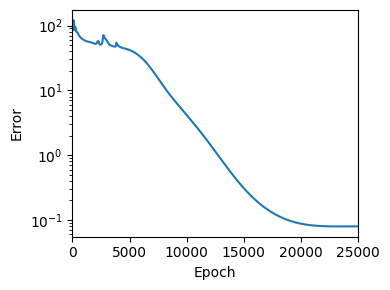

In [10]:
figure(figsize=(4,3))
semilogy(error_arr); ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

## 学習後の出力の確認

In [11]:
error, ŷ, h = update!(rnn, rnn.param, x, y, false)
println("Error : ", sum(error.^2))

Error : 0.07971189973237974


見やすいように出力のピークに応じて中間層のユニットをソートする．

In [12]:
max_idx = Tuple.(argmax(h[1, :, :]', dims=2))
h_ = h[1, :, sortperm(last.(max_idx)[:, 1])];

出力層，中間層の出力を描画する．

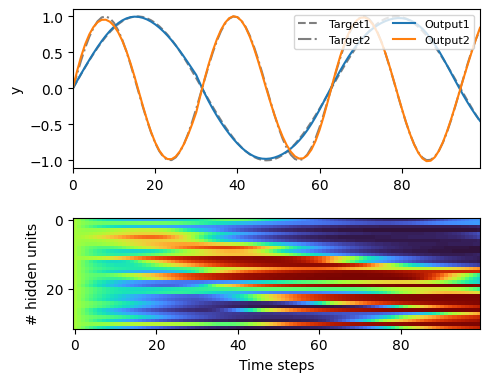

In [13]:
figure(figsize=(5, 4))
subplot(2,1,1)
plot(tsteps, y[1, :, 1], "--k", alpha=.5, label="Target1")
plot(tsteps, y[1, :, 2], "-.k", alpha=.5, label="Target2")
plot(tsteps, ŷ[1, :, 1], label="Output1")
plot(tsteps, ŷ[1, :, 2], label="Output2")
ylabel("y"); xlim(0, tsteps[end])
legend(loc="upper right", ncol=2, fontsize=8)

subplot(2,1,2)
imshow(h_', cmap="turbo", aspect=0.85)
xlabel("Time steps"); ylabel("# hidden units")

tight_layout()